## Last week

We saw three out of four ways to perform webscraping:

- When the information is hardcoded in the HTML of a website.
- When the information is in an external database with an unprotected API
- When the information is in an external database with a barely protected API

## Today

We finish with the final way to webscrape:

- When the information is in an external database with a protected API

We correct past week's exercise:

- Use of pandas with eurostat package

We start with text analysis

Let's dive in the worst and final category of web scraping - when an API is not available, and you cannot use request because there's too much javascript.

- Corresponds to most cases where there's money involved and a private firm:
    - Airbnb/Booking
    - Yelp/google reviews
    - Amazon/Online stores

They're not going to let you in their internal database that easily. You have to navigate the HTML to make them give you the data.

For these website, you need a much stronger tool than the ones we use. It's called `Selenium`, it can do everything, but it's very slow, and it bugs a lot.

- It's like the webscraper's nuclear weapon, and you should try never to use it.

To test its use, we'll use a very 25th of April themed website: http://dati.acs.beniculturali.it/CPC/

- I actually found the way to access the external database, but pretend that you cannot find it.

In those cases, which will be frequent, especially in commercial applications you need another solution

Before we turn to the solution to that problem, let's look at what happens when we use requests

In [3]:
import requests
from bs4 import BeautifulSoup

# Do the usual, take link and parse it
page_response = requests.get('http://dati.acs.beniculturali.it/CPC/')
page_content = BeautifulSoup(page_response.content, 'html.parser')

# The dataset is in a div with id z-cards
data = page_content.find('div', id="z-cards").text

# It's empty
print(data)

In the request, the data we are interested in is nowhere to be found. That's because the HTML code of this website is constructed to be a receptacle of the data from the external database.

Only once the Javascript is ran the data appears in the HTML. Since we cannot access the external database, we must force the HTML to get the data

In [14]:
!pip install selenium -U

  Using cached selenium-4.20.0-py3-none-any.whl.metadata (6.9 kB)
Using cached selenium-4.20.0-py3-none-any.whl (9.5 MB)
  Attempting uninstall: selenium
    Found existing installation: selenium 3.141.0
    Uninstalling selenium-3.141.0:
      Successfully uninstalled selenium-3.141.0


In [4]:
from selenium import webdriver
from selenium.webdriver.common.by import By

driver = webdriver.Chrome()

With selenium, we're opening up a webpage from a browser as if we were the one navigating:

- It's as if we were actually using google chrome
- We force websites into believe we're a user with a browser, thus triggering the javascript

In [5]:
# Let's open the webpage
driver.get('http://dati.acs.beniculturali.it/CPC/')
driver.maximize_window()

- In spite of being not the best way to do scraping, it might be the most intuitive because it's very close to what you would be doing if you were not programming. 

- You can do with the code anything you would do by hand. Click on a button, write text in a cell, log in to a website. It's very flexible.

- The way to access HTML element is the same, the syntax is different because you're using a new set of python function

On python selenium, you have several way to pass information, the one I find myself most confortable with is `xpath`, you're free to use whichever you prefer though.

- An xpath is an html path that allows to access an element - for example the `span` that contains the button "tabella":

`"//span[contains(text(), 'tabella')]"`

Looking for any tag that is a `span` tag and contains the word "tabella" inside of its text.

In [6]:
element_to_click = driver.find_element(By.XPATH, "//span[contains(text(), 'tabella')]")

In [7]:
element_to_click

<selenium.webdriver.remote.webelement.WebElement (session="1cb41ab5f065742c3df16b719a611df9", element="f.800D31019C9D128B487EFFF78E8A5A71.d.315C6CEA9A032430FBE25F65515F8D8E.e.89")>

Now, I just use the `selenium` functions to `.click()` that element

In [10]:
element_to_click.click()

The information is collected, the table can be scraped.

Download these libraries to be able to directly import an html table to pandas

In [50]:
!pip install lxml
!pip install html5lib

   ---------------------------------------- 0.0/112.2 kB ? eta -:--:--
   --- ------------------------------------ 10.2/112.2 kB ? eta -:--:--
   ------------------------ -------------- 71.7/112.2 kB 787.7 kB/s eta 0:00:01
   -------------------------------------- 112.2/112.2 kB 935.2 kB/s eta 0:00:00


In [11]:
import pandas as pd
from io import StringIO  
table = driver.find_element(By.XPATH, '//div[@id="z-table"]//table[@class="zTable"]')
df = pd.read_html(StringIO(table.get_attribute('outerHTML')))[0]

We have the information from the webpage

In [26]:
print(df)

C:\Users\anato\anaconda3\envs\python-econ\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
C:\Users\anato\anaconda3\envs\python-econ\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
C:\Users\anato\anaconda3\envs\python-econ\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
C:\Users\anato\anaconda3\envs\python-econ\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)


NameError: name 'df' is not defined

And then we would move on to the next page

In [14]:
# Get the first li
ii = 3
driver.find_element(By.XPATH, f'//a[@title="pagina {ii}"]').click()

Each time you would take the information, exactly as we did with the package requests.

Let's practice and build a simple code that would take everything

In [15]:
from time import sleep
from tqdm import trange

In [16]:
full_info = list()

# Open, get to the correct page, click the tabella link
driver = webdriver.Chrome()
driver.get('http://dati.acs.beniculturali.it/CPC/')
driver.maximize_window()

sleep(3)
driver.find_element(By.XPATH, "//span[contains(text(), 'tabella')]").click()

for ii in trange(2, 10173):
    # Get the info
    table = driver.find_element(By.XPATH, '//div[@id="z-table"]//table[@class="zTable"]')
    df = pd.read_html(StringIO(table.get_attribute('outerHTML')))[0]
    full_info.append(df)
    # Move on
    driver.find_element(By.XPATH, f'//a[@title="pagina {ii}"]').click()
    sleep(3)
    

  0%|▏                                                                            | 26/10171 [01:22<8:56:36,  3.17s/it]


KeyboardInterrupt: 

### If it works all the time, why not using it by default?

- Webscraping is about saving time on what you would normally do by hand. Selenium in some cases is much slower than other softwares.
- Selenium makes a lot of errors.
- Selenium does not allow you to come back.

My advice:

- Limit the use of `Selenium` for website that use proprietary and commercial data, or for quick & dirty work

## Before we end webscraping

### Congratulations, now you know the general methodology behind webscraping, and the libraries to use (and how)!

- Each individual case will still require you to investigate quite a bit and to google information.

I just want to mention other individual cases you might encounter:

- Let's say you need to use google. Use `duckduckgo_search` you can search the internet from duckduckgo (much like google).
    - You can limite the search to a specific domain in the internet: "site:https://www.topuniversities.com/universities"
- If you need to organize regular scraping, use `scrapy`.
- Google trend: you can get data from online, and it can be very interesting in some cases.
    - https://trends.google.com/trends/

## Before we do text analysis

There were some errors with `pandas` and `eurostat` a lot of you did during the homework. I want to go back on those. Let's do the assignment of last week together. Some commons mistake we need to address:

- `pd.melt` without taking into account all relevant columns.
- `.mean()` without taking into account different units.
- Computing `.var()` without taking into account the time dimension.
- Using `.mean()` when the weights already summed up to 1.

Let's first import data on GDP.

In [1]:
# Import relevant packages
import pandas as pd   # Data management
import eurostat       # Import directly from eurostat
import re             # Package for pattern recognition
import numpy as np


# Let's first create a dictionary to pass exactly the options that we want
data_options = {
    'unit' : 'MIO_EUR'     # Filter for "Million euro"
}


# Get the dataframe and rename columns improperly parsed
data_gdp = eurostat.get_data_df('nama_10r_2gdp', filter_pars=data_options) 
data_gdp = data_gdp.rename(columns={'geo\\TIME_PERIOD':'geo'})

data_gdp1 and data_gdp2 should be exactly the same
- The dictionary you input in `filter_pars` is a `eurostat` command to let them know you do not want all the data

In [2]:
# Let's first create a dictionary to pass exactly the options that we want
data_options = {
    'unit' : 'MIO_EUR'     # Filter for "Million euro"
}

# Get the dataframe and rename columns improperly parsed
data_gdp1 = eurostat.get_data_df('nama_10r_2gdp', filter_pars=data_options) 

# Or this one
data_gdp2 = eurostat.get_data_df('nama_10r_2gdp') 
data_gdp2 = data_gdp2.loc[data_gdp2['unit'] == 'MIO_EUR']

The merging of the data and selection of the nuts2 with an external database went okay for pretty much everyone.

In [3]:
# Get the dataframe with the name of the nuts
name_of_nuts = pd.read_csv('https://raw.githubusercontent.com/datumorphism/dataset-eu-nuts/master/dataset/nuts_v2021__2021_.csv')

# Keep the natural name (nuts_2 and nuts_level)
name_of_nuts = name_of_nuts[['nuts_code', 'nuts_level', 'nuts_2']]

# And merge it with your dataset
data_gdp = pd.merge(data_gdp, name_of_nuts, how = 'left', left_on = 'geo', right_on = 'nuts_code')

# Here keep only nuts 2 level
data_gdp = data_gdp.loc[data_gdp['nuts_level'] == 2, ]
data_gdp = data_gdp.drop('nuts_level', axis = 1)

Then the melting: very important, I am putting all the variables into id_vars that are not years:

- It was very important to filter the data one way or another!
- draw on the board what happens if we don't

In [4]:
# Then we can melt the dataset (see class3)
data_gdp = data_gdp.melt(id_vars = ['geo', 'nuts_2', 'freq', 'unit'], 
                                 var_name = 'date', 
                                 value_name = 'gdp')

# At this stage we can remove the NaN (see class3 again)
data_gdp = data_gdp.dropna(subset = 'gdp')

# And subselect only the interesting columns
data_gdp = data_gdp[['geo', 'nuts_2', 'date', 'gdp']]

Take the population data. Again, don't forget to put all relevant variables in the melting, or to remove these columns before if they only feature one unique value

In [5]:
# Let's first create a dictionary to pass exactly the options that we want
data_options = {
    'sex' :'T', # Filter for "Total" population (gender dimension)
    'age' : 'TOTAL'  # Filter for "Total" population (age dimension)
}


# Get the dataframe and rename columns improperly parsed
data_population = eurostat.get_data_df('demo_r_d2jan', filter_pars=data_options) 
data_population = data_population.rename(columns={'geo\\TIME_PERIOD':'geo'})

# Melt the data here again
data_population = data_population.melt(id_vars = ['freq' ,'unit', 'sex', 'age', 'geo'], 
                                         var_name = 'date', 
                                         value_name = 'pop')
data_population = data_population.dropna(subset = 'pop')

Merge the two datasets:

- Don't forget that those datasets have two dimensions!
- What happens if we do not specify both "date" and "geo"?

In [6]:
# Perform the merge
data_full = pd.merge(data_gdp, data_population, how = 'left', on = ['date', 'geo'])

# Keep only columns ['date', 'geo', 'agri_output', 'pop']
data_full = data_full[['date', 'geo', 'nuts_2', 'gdp', 'pop']]
data_full = data_full.dropna(subset = ['gdp', 'pop'])

# Transform date to a numeric object
data_full['date'] = pd.to_numeric(data_full['date'])
data_full = data_full.loc[data_full['date'] >= 2015]

# Create gdp per capita
data_full['gdp_per_cap'] = data_full['gdp']/data_full['pop']

Get the country - compute the average gdp per capita of each NUTS2 on the period

In [11]:
# Make up a column equal to countr
data_full['country'] = data_full['geo'].apply(lambda x: x[:2])

# This computes the average over the last 10 years
data_gdp_per_cap = data_full.groupby(['country', 'geo', 'nuts_2'])[['gdp_per_cap', 'pop']].mean()

# reset the index, makes the dataset non-grouped anymore
data_gdp_per_cap = data_gdp_per_cap.reset_index(drop = False)

data_gdp_per_cap.sample(n=5)

,country,geo,nuts_2,gdp_per_cap,pop
127,FR,FRB0,Centre — Val de Loire,0.028922,2572650.375
150,FR,FRY3,Guyane,0.015387,278853.000
96,EL,EL54,Ήπειρος,0.011867,332839.375
172,IT,ITF1,Abruzzo,0.02503,1305884.750
281,TR,TR83,"Samsun, Tokat, Çorum, Amasya",0.00561,2783971.500


We have averaged gdp per capita - I have only one value per NUTS2

- If i did not filter for the unit, I would have many more

In [34]:
data_gdp_per_cap['geo'].value_counts()

geo
AL01    1
PL42    1
NL12    1
NL11    1
MT00    1
       ..
EL54    1
EL53    1
EL52    1
EL51    1
TRC3    1
Name: count, Length: 290, dtype: int64

We're ready to compute unweighted variance

In [38]:
# First compute the unweighted one
unweigthed = data_gdp_per_cap.groupby('country')['gdp_per_cap'].var().sort_values().dropna()
print(unweigthed.tail(n=5))

country
CZ    0.000107
SK    0.000167
DK    0.000168
BE    0.000189
IE    0.000845
Name: gdp_per_cap, dtype: object


What if you wanted to compute variance yearly then average it? - then it's very important you think about the year structure:

- If a country is fully equal, but you do it without the year you will find that there is variance when there really shouldn't be any.

Let's do an example. 

- India has 3 NUTS2, it's a country with full equality between regions.
- Bangladesh has 2 NUTS2 there is inequality. 

We observe both countries for 3 years, they both grow by a 100% a year

In [24]:
data_south_asia = pd.DataFrame({
    "country" : ['india', 'india', 'india', 'bangladesh', 'bangladesh'],
    "geo" : ["delhi", "kolkata", "mumbai", 'dhaka', 'rangpur'],
    "2015" : [1, 1, 1, 1, 2],
    "2016" : [2, 2, 2, 1, 3],
    "2017" : [4, 4, 4, 2, 4]
})
print(data_south_asia)
data_south_asia = pd.melt(data_south_asia, id_vars = ["country", "geo"], value_name= "gdp", var_name="date")

      country      geo  2015  2016  2017
0       india    delhi     1     2     4
1       india  kolkata     1     2     4
2       india   mumbai     1     2     4
3  bangladesh    dhaka     1     1     2
4  bangladesh  rangpur     2     3     4


Let's see here, that if I ignore the time dimension I get a false result:

In [25]:
variance = data_south_asia.groupby('country')['gdp'].var()
print(variance)

country
bangladesh    1.366667
india         1.750000
Name: gdp, dtype: float64


India has a higher variance than Bangladesh, yet India has full equality!

The correct way to do things is to take the date into account:

In [26]:
# This computes the average over the last 10 years
correct = data_south_asia.groupby(['country', 'date'])[['gdp']].var().reset_index(drop = False)
correct.groupby('country')['gdp'].mean()

country
bangladesh    1.5
india         0.0
Name: gdp, dtype: float64

The result changed dramatically!

- The acceptable alternative way was to first compute variance, without forgetting about the years, then computing the average

For the weighted average, the formula was a bit more convoluted

In [51]:
# Then compute the weighted one
mean_per_country = data_gdp_per_cap.groupby('country').apply(lambda x: np.average(x['gdp_per_cap'], weights=x['pop']), include_groups=False)

weighted_mean = lambda x: np.average(x['gdp_per_cap'], weights=x['pop'])
# Step 2: Calculate weighted standard deviation for each country
def weighted_std(group):
    weights = group['pop']
    mean = weighted_mean(group)
    weighted_sum_squares = np.sum(weights * (group['gdp_per_cap'] - mean) ** 2)
    weighted_variance = weighted_sum_squares / np.sum(weights)
    return(weighted_variance)

data_sd_weighted = data_gdp_per_cap.groupby('country').apply(weighted_std, include_groups = False).sort_values()

## Text Analysis

Let's start with text analysis. An incredibly useful and somewhat untapped source of information in economics.

What is text analysis?

Imagine you have a text or a text corpora you might, from easiest to hardest:

- Want to extract some information from the each piece of text that you know is there.
- Identify most defining words in a piece of text
- Measure the sentiment in the text.
- Measure the breadth of vocabulary (complexity) being used in a text.
- Cluster different elements of a corpora into a defined number of different unknown arguments.
- Cluster very large corpora of text into an unknown number of different arguments.

## A bit of Vocabulary

- We will usually have a `corpus` of text documents
- Each text document will have a number of words/tokens/characters
- In each text document, we will want to access relevant information:
    - That will very often mean getting rid first of useless information.
    - The trick is figuring out how to retain valuable information.
    
In many application, you want to create a text **meta**data

Recently there was a game changer in the field of text analysis:

- Arrival of LLM models.
    - The impact of such models on how we do analysis is still to be understood.
    - It's hard to tell right now how it will change how we usually think about text analysis.
- It might be important for you to learn how to use LLM models from python.
    - We will do also that.

A word of caution:

- Perhaps 80% of the work in text analysis is actually cleaning the text to remove `noisy non-information`.
- Removing noisy non-information is text/project specific, some routines are common, but you have to think hard about what we're doing.
- Today we won't be doing so much of that, tomorrow, by comparison, we will. We'll see how that affects results.

## Regular Expressions

An expression that is regular in a corpus of text.

- When you construct a database based on many documents, it can happen that the information is always organized in a similar way
    - The information is then called `regular`
    - You would extract it by matching `pattern` using these `regular expressions`

### The weakest form of text analysis

Regular expressions are not so much text analysis as a pre-requisite to perform it:

- It's more about extracting or identifying information in a regularly written corpora

It's great to have some notions of what you can do with text analysis

### Regular expression example

To study this question, let's use a dataset of ECB members interviews to the press

https://www.ecb.europa.eu/press/pubbydate/html/index.en.html?name_of_publication=Interview&year=2017

Let's webscrape the interviews then study those with regular expression

In [27]:
# First we webscrape the interviews themselves - it's a website that uses javascript
from selenium import webdriver
from selenium.webdriver.common.by import By
from time import sleep

# Get hte linkes
driver = webdriver.Chrome() 
driver.get("https://www.ecb.europa.eu/press/pubbydate/html/index.en.html?name_of_publication=Interview&year=2017")

# Wait for the javascript to load
sleep(3)

# Scroll down on page to load the webpage elements
for ii in range(4):
    # Scroll down multiple time to load all javascript elements
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    sleep(1)

# Urls
urls = driver.find_elements(By.XPATH,'//dl//div[@class="title"]//a')
urls = [x.get_attribute('href') for x in urls]

Now we use `requests` to get all the speeches

In [28]:
list_speeches = list()
for url in urls:
    
    page_response = requests.get(url)
    page_content = BeautifulSoup(page_response.content, 'html.parser')
    interview = page_content.find('main')
    
    title = interview.find('div', attrs = {'class':'title'}).text.strip()
    corpus = interview.find('div', attrs = {'class':'section'}).text.strip()
    list_speeches.append([title, corpus])

dataset = pd.DataFrame(list_speeches, columns = ['title', 'content'])

Let's have a look at the data we just scraped

In [69]:
dataset.sample(n=5)

,title,content
21,Interview with Peter Praet for Trends/Tendances,"Interview with Peter Praet, Member of the Exec..."
23,Interview with VDI Nachrichten,"Interview with Peter Praet, Member of the Exec..."
4,Interview with Le Journal du Dimanche,"Interview with Benoît Cœuré, Member of the Exe..."
0,Interview with Caixin Global,"Interview with Benoît Cœuré, Member of the Exe..."
14,We need a coordinated European NPL strategyHow...,"Opinion piece by Vítor Constâncio, Vice-Presid..."


We will use regular expression to extract:

- Interviewer's company
- Interviewer(s)
- Interviewee(s)
- date of interview

#### Interviewers' company

If there is one, it's always in the title. It might be separated by and end. The pattern is always:

- `beginning of sentence` Interview with `names to extract` `end of sentence`

Full dictionary available at: https://docs.python.org/3/library/re.html

In [40]:
dataset

,title,content,institution
0,Interview with Caixin Global,"Interview with Benoît Cœuré, Member of the Exe...",Interview with Caixin Global
1,Interview with Börsen-Zeitung,"Interview with Yves Mersch, Member of the Exec...",Interview with Börsen-Zeitung
2,Interview with Handelsblatt,"Interview with Benoît Cœuré, Member of the Exe...",Interview with Handelsblatt
3,Interview with France Info TV,"Interview with Benoît Cœuré, Member of the Exe...",Interview with France Info TV
4,Interview with Le Journal du Dimanche,"Interview with Benoît Cœuré, Member of the Exe...",Interview with Le Journal du Dimanche
5,Interview with Les Echos,"Interview with Peter Praet, Member of the Exec...",Interview with Les Echos
6,Interview with Euronews,"Interview with Vítor Constâncio, Vice-Presiden...",Interview with Euronews
7,Interview with De Tijd,"Interview Peter Praet, Member of the Executive...",Interview with De Tijd
8,Europe’s moment,"Opinion piece by Benoît Cœuré, Member of the E...",Europe’s moment
9,The role of cash: Customer retention and tie t...,"Contribution by Yves Mersch, Member of the Exe...",The role of cash: Customer retention and tie t...


In [41]:
import re

def extract_interview_entity(title):
    names = re.search('(?<=Interview with)\\s*(.*?)\\s*$', title)
    
    if names:
        names = names.group(1)
    else:
        names = "Not applicable"
    return(names)

dataset['institution'] = dataset['title'].apply(lambda x:extract_interview_entity(x))

In [122]:
dataset

,title,content,names
0,Interview with Caixin Global,"Interview with Benoît Cœuré, Member of the Exe...",Caixin Global
1,Interview with Börsen-Zeitung,"Interview with Yves Mersch, Member of the Exec...",Börsen-Zeitung
2,Interview with Handelsblatt,"Interview with Benoît Cœuré, Member of the Exe...",Handelsblatt
3,Interview with France Info TV,"Interview with Benoît Cœuré, Member of the Exe...",France Info TV
4,Interview with Le Journal du Dimanche,"Interview with Benoît Cœuré, Member of the Exe...",Le Journal du Dimanche
5,Interview with Les Echos,"Interview with Peter Praet, Member of the Exec...",Les Echos
6,Interview with Euronews,"Interview with Vítor Constâncio, Vice-Presiden...",Euronews
7,Interview with De Tijd,"Interview Peter Praet, Member of the Executive...",De Tijd
8,Europe’s moment,"Opinion piece by Benoît Cœuré, Member of the E...",Not applicable
9,The role of cash: Customer retention and tie t...,"Contribution by Yves Mersch, Member of the Exe...",Not applicable


#### Interviewees

Here there are several possibility, interview/piece/contribution, spaces, then with|of|by

- remember the link to the library: https://docs.python.org/3/library/re.html

In [42]:
def extract_interviewee(title):
    names = re.search('(Interview|piece|Contribution)\\s*(with|of|by)?\\s*(.*?),', title)
    
    if names:
        names = names.group(3)
    else:
        names = "Not applicable"
    return(names)

# Then get the names of the interviewees
dataset['interviewee'] = dataset['content'].apply(lambda x: extract_interviewee(x))


In [127]:
dataset

,title,content,names,interviewee
0,Interview with Caixin Global,"Interview with Benoît Cœuré, Member of the Exe...",Caixin Global,Benoît Cœuré
1,Interview with Börsen-Zeitung,"Interview with Yves Mersch, Member of the Exec...",Börsen-Zeitung,Yves Mersch
2,Interview with Handelsblatt,"Interview with Benoît Cœuré, Member of the Exe...",Handelsblatt,Benoît Cœuré
3,Interview with France Info TV,"Interview with Benoît Cœuré, Member of the Exe...",France Info TV,Benoît Cœuré
4,Interview with Le Journal du Dimanche,"Interview with Benoît Cœuré, Member of the Exe...",Le Journal du Dimanche,Benoît Cœuré
5,Interview with Les Echos,"Interview with Peter Praet, Member of the Exec...",Les Echos,Peter Praet
6,Interview with Euronews,"Interview with Vítor Constâncio, Vice-Presiden...",Euronews,Vítor Constâncio
7,Interview with De Tijd,"Interview Peter Praet, Member of the Executive...",De Tijd,Peter Praet
8,Europe’s moment,"Opinion piece by Benoît Cœuré, Member of the E...",Not applicable,Benoît Cœuré
9,The role of cash: Customer retention and tie t...,"Contribution by Yves Mersch, Member of the Exe...",Not applicable,Yves Mersch


### Interviewer's names

Exercice: do it yourself. look at https://docs.python.org/3/library/re.html

In [56]:
dataset.sample(n=2)

,title,content,institution,interviewee,interviewer
13,Interview with Le Monde and La Stampa,"Interview with Benoît Cœuré, Member of the Executive Board of the ECB, conducted by Marie Charrel (Le Monde) and Alessandro Barbera (La Stampa), on 3 July, ...",Le Monde and La Stampa,Benoît Cœuré,Marie Charrel (Le Monde) and Alessandro Barbera (La Stampa)
25,Interview with Deutschlandfunk,"Interview with Sabine Lautenschläger, Member of the Executive Board of the ECB and Vice-Chair of the Supervisory Board of the ECB,conducted by Klemens Kinde...",Deutschlandfunk,Sabine Lautenschläger,Klemens Kindermann


In [54]:
def extract_interviewer(title):
    names = re.search('(conducted|published)\\s*(by)\\s*(.*?)(and published|,|on)\\s+', title)
    
    if names:
        names = names.group(3)
    else:
        names = "Not applicable"
    return(names)

# Then get the names of the interviewees
dataset['interviewer'] = dataset['content'].apply(lambda x: extract_interviewer(x))

In [51]:
pd.options.display.max_colwidth = 160
dataset[['content']]

,content
0,"Interview with Benoît Cœuré, Member of the Executive Board of the ECB, conducted by Liwei Wang on 17 December and published on 30 December 2017\nI. Europe\n..."
1,"Interview with Yves Mersch, Member of the Executive Board of the ECB, conducted by Mark Schrörs und Detlef Fechtner on 18 December and published on 29 Decem..."
2,"Interview with Benoît Cœuré, Member of the Executive Board of the ECB, conducted by Jan Mallien and Frank Wiebe on 15 November and published on 21 November ..."
3,"Interview with Benoît Cœuré, Member of the Executive Board of the ECB, conducted by Jean-Paul Chapel on 9 November 2017\nGlobal indebtedness is at record le..."
4,"Interview with Benoît Cœuré, Member of the Executive Board of the ECB, conducted by Bruna Basini on 27 October and published on 29 October 2017\nThe reducti..."
5,"Interview with Peter Praet, Member of the Executive Board of the ECB, conducted by Isabelle Couet and Catherine Chatignoux on 25 September and published on ..."
6,"Interview with Vítor Constâncio, Vice-President of the ECB, conducted by Efthymia Koutsokosta on 15 September and published on 20 September\nAfter almost a ..."
7,"Interview Peter Praet, Member of the Executive Board of the ECB, conducted by Wouter Vervenne and Bart Haeck on 13 September and published on 16 September 2..."
8,"Opinion piece by Benoît Cœuré, Member of the Executive Board of the ECB, published by Börsen-Zeitung, 12 September 2017\nGlobalisation and international coo..."
9,"Contribution by Yves Mersch, Member of the Executive Board of the ECB, 1 September 2017\nThere is much talk about the demise of cash. But to paraphrase Mark..."


## Interview date

On the first paragraph, a final on leads to a date finished by the year which finishes the line

In [57]:
def extract_date(title):
    names = re.search(r'(\d?\d\s*[a-zA-Z]+\s*\d{4})\n', title)
    
    if names:
        names = names.group(1)
    else:
        names = "Not applicable"
    return(names)

dataset['date'] = dataset['content'].apply(lambda x: extract_date(x))


In [58]:
dataset

,title,content,institution,interviewee,interviewer,date
0,Interview with Caixin Global,"Interview with Benoît Cœuré, Member of the Executive Board of the ECB, conducted by Liwei Wang on 17 December and published on 30 December 2017\nI. Europe\n...",Caixin Global,Benoît Cœuré,Liwei Wang,30 December 2017
1,Interview with Börsen-Zeitung,"Interview with Yves Mersch, Member of the Executive Board of the ECB, conducted by Mark Schrörs und Detlef Fechtner on 18 December and published on 29 Decem...",Börsen-Zeitung,Yves Mersch,Mark Schrörs und Detlef Fechtner,29 December 2017
2,Interview with Handelsblatt,"Interview with Benoît Cœuré, Member of the Executive Board of the ECB, conducted by Jan Mallien and Frank Wiebe on 15 November and published on 21 November ...",Handelsblatt,Benoît Cœuré,Jan Mallien and Frank Wiebe,21 November 2017
3,Interview with France Info TV,"Interview with Benoît Cœuré, Member of the Executive Board of the ECB, conducted by Jean-Paul Chapel on 9 November 2017\nGlobal indebtedness is at record le...",France Info TV,Benoît Cœuré,Jean-Paul Chapel,9 November 2017
4,Interview with Le Journal du Dimanche,"Interview with Benoît Cœuré, Member of the Executive Board of the ECB, conducted by Bruna Basini on 27 October and published on 29 October 2017\nThe reducti...",Le Journal du Dimanche,Benoît Cœuré,Bruna Basini,29 October 2017
5,Interview with Les Echos,"Interview with Peter Praet, Member of the Executive Board of the ECB, conducted by Isabelle Couet and Catherine Chatignoux on 25 September and published on ...",Les Echos,Peter Praet,Isabelle Couet and Catherine Chatignoux,29 September 2017
6,Interview with Euronews,"Interview with Vítor Constâncio, Vice-President of the ECB, conducted by Efthymia Koutsokosta on 15 September and published on 20 September\nAfter almost a ...",Euronews,Vítor Constâncio,Efthymia Koutsokosta,Not applicable
7,Interview with De Tijd,"Interview Peter Praet, Member of the Executive Board of the ECB, conducted by Wouter Vervenne and Bart Haeck on 13 September and published on 16 September 2...",De Tijd,Peter Praet,Wouter Vervenne and Bart Haeck,16 September 2017
8,Europe’s moment,"Opinion piece by Benoît Cœuré, Member of the Executive Board of the ECB, published by Börsen-Zeitung, 12 September 2017\nGlobalisation and international coo...",Not applicable,Benoît Cœuré,Börsen-Zeitung,12 September 2017
9,The role of cash: Customer retention and tie to the citizen,"Contribution by Yves Mersch, Member of the Executive Board of the ECB, 1 September 2017\nThere is much talk about the demise of cash. But to paraphrase Mark...",Not applicable,Yves Mersch,Not applicable,1 September 2017


## Dictionary-Based Methods

## Descriptive methods

###  Extracting regular information - bag of words methods


- Very useful in time series, to roughly identify whether a text mentions a certain subject
- How much does the ECB speak about inflation/deflation/fiscal policies for example?

Let's re-use the webscraper, and get all the interviews since 2000.

- Define some policy areas, and identify how much they were discussed by the ECB in interviews.

In [1]:
# First we webscrape the interviews themselves - it's a website that uses javascript
from selenium import webdriver
from selenium.webdriver.common.by import By
from time import sleep

# Get hte linkes
driver = webdriver.Chrome() 
base_url = "https://www.ecb.europa.eu/press/pubbydate/html/index.en.html?name_of_publication=Interview&year="

urls = list()

for year in range(2004, 2024):
    
    # Get the link
    sleep(3)
    driver.get(f'{base_url}{year}')
    
    # Scroll down on page to load the webpage elements
    for ii in range(8):
        # Scroll down multiple time to load all javascript elements
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        sleep(1)

    # Urls
    urls_year = driver.find_elements(By.XPATH,'//dl//div[@class="title"]//a')
    urls_year = [x.get_attribute('href') for x in urls_year]
    [urls.append([year, x]) for x in urls_year]

dataset_url_int = pd.DataFrame(urls, columns = ['year', 'url'])
dataset_url_int.to_csv('url_from_ecb.csv', index = False)

NameError: name 'pd' is not defined

Now that we have all the links, let's get the interviews and study how ECB interviews have evolved through time, and whether their communication reflects the worries of each given year

In [5]:
from tqdm import trange
import requests
from bs4 import BeautifulSoup
list_speeches = list()

for idx in trange(len(urls)):
    year, url = urls[idx]
    sleep(1)
    page_response = requests.get(url)
    page_content = BeautifulSoup(page_response.content, 'html.parser')
    interview = page_content.find('main')
    try:
        title = interview.find('div', attrs = {'class':'title'}).text.strip()
        corpus = interview.find('div', attrs = {'class':'section'}).text.strip()
        list_speeches.append([year, title, corpus])
    except:
        continue

dataset = pd.DataFrame(list_speeches, columns = ['year', 'title', 'content'])

100%|████████████████████████████████████████████████████████████████████████████████| 527/527 [12:23<00:00,  1.41s/it]


Now that we have the speeches, we create `bag of words`, simple lists, containing words pertaining to a given theme we want to track the relevance of in the ECB speeches:

- Inflation: \[inflation, price level, money supply, price stability\]
- Fiscal policy: \[debt, deficit, fiscal, tax, stimulus, budget\]
- anxiety: \[crisis, explosion, preoccupation, financial risk\]

You compute the number of words in a text, you divide the number of matches by the number of occurence of each bag of word found

In [59]:
# Create the bag of words
inflation = ["inflation", "price level", "money supply", "price stability"]
fiscal = ["debt", "deficit", "fiscal", "tax", "stimulus", "budget", 'esm']
anxiety = ["crisis", "explosion", "preoccupation", "financial risk", 'growth', 'recession']

In [60]:
# Create a simple function that returns the number of times the patterns were found and return the number of matches
def bag_counts(x):
    
    # Count every occurences 
    count_infl = [x.lower().count(y) for y in inflation]
    count_fisc = [x.lower().count(y) for y in fiscal]
    count_anxi = [x.lower().count(y) for y in anxiety]
    
    # Count the number of words in the corpus
    nbr_words = len(x.split(' '))
    
    return([sum(count_infl)/nbr_words, sum(count_fisc)/nbr_words, sum(count_anxi)/nbr_words])
    
bag_counts(
    """
    money supply is too high, we are afraid inflation might pick up and threaten price stability
    it might be good to alleviate public debt, but we're afraid a crisis is looming with a risk
    to enter hyperinflation.
    """
)

[0.0784313725490196, 0.0196078431372549, 0.0196078431372549]

We can now apply this function to our dataset

In [61]:
dataset = pd.read_csv(r"C:\Users\anato\Documents\travail\courses\python-for-economist\class7\interviews.csv")
dataset[['inflation', 'fiscal', 'crisis']] = dataset['content'].apply(lambda x: bag_counts(x)).tolist()
dataset = dataset.groupby('year')[['inflation', 'fiscal', 'crisis']].mean()

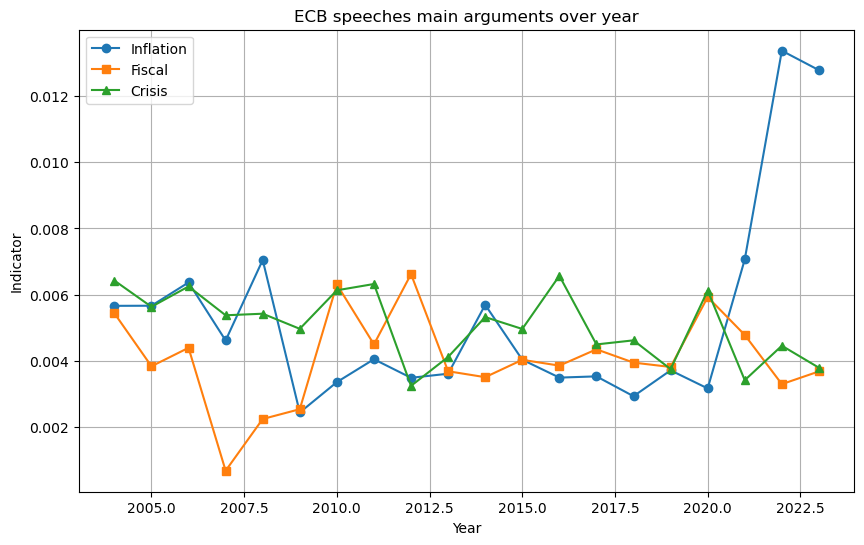

In [62]:
import matplotlib.pyplot as plt
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(dataset.index, dataset['inflation'], label='Inflation', marker='o')
plt.plot(dataset.index, dataset['fiscal'], label='Fiscal', marker='s')
plt.plot(dataset.index, dataset['crisis'], label='Crisis', marker='^')
plt.title('ECB speeches main arguments over year')
plt.xlabel('Year')
plt.ylabel('Indicator')
plt.legend()
plt.grid(True)
plt.show()

What if we only look at subject of the interview?

In [63]:
# Create a simple function that returns the number of times the patterns were found and return the number of matches
def bag_identify(x):
    
    # Count every occurences 
    count_infl = sum([x.lower().count(y) for y in inflation])
    count_fisc = sum([x.lower().count(y) for y in fiscal])
    count_anxi = sum([x.lower().count(y) for y in anxiety])
    
    most_important = [count_infl, count_fisc, count_anxi].index(max([count_infl, count_fisc, count_anxi]))
    
    # Identify the most important argument
    arguments = [int(0==most_important), int(1==most_important), int(2==most_important)]
    
    return(arguments)

In [64]:
dataset = pd.read_csv(r"C:\Users\anato\Documents\travail\courses\python-for-economist\class7\interviews.csv")
dataset[['inflation', 'fiscal', 'crisis']] = dataset['content'].apply(lambda x: bag_identify(x)).tolist()
dataset = dataset.groupby('year')[['inflation', 'fiscal', 'crisis']].mean()

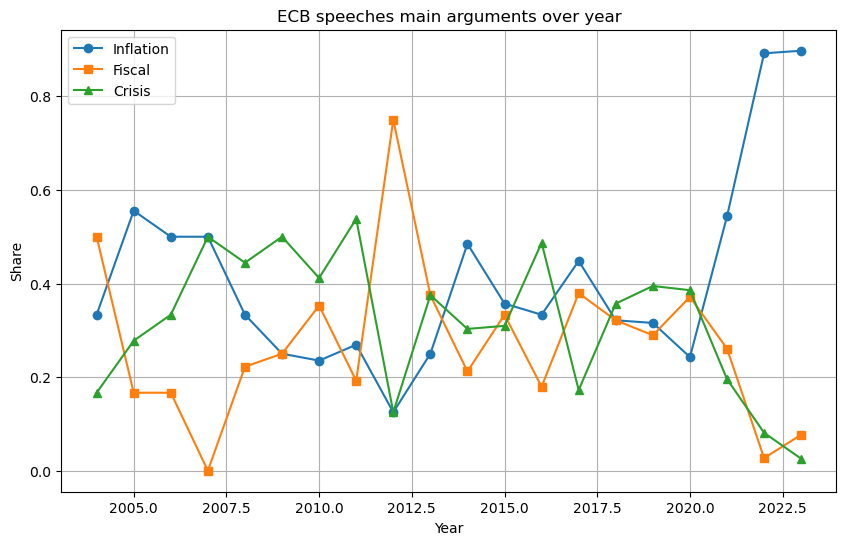

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(dataset.index, dataset['inflation'], label='Inflation', marker='o')
plt.plot(dataset.index, dataset['fiscal'], label='Fiscal', marker='s')
plt.plot(dataset.index, dataset['crisis'], label='Crisis', marker='^')
plt.title('ECB speeches main arguments over year')
plt.xlabel('Year')
plt.ylabel('Share')
plt.legend()
plt.grid(True)
plt.show()

## Descriptive Methods

### Search for the sentiment of a text - Dictionary based

You use a dictionary of text that records which words are "positive" and which words are "negative".

- In general pretty good at guessing the sentiment in a text.

And still you would get bias

In [43]:
!pip install -U textblob

   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   - -------------------------------------- 30.7/626.3 kB 1.3 MB/s eta 0:00:01
   --------------- ------------------------ 245.8/626.3 kB 5.0 MB/s eta 0:00:01
   -------------------------------- ------- 501.8/626.3 kB 6.2 MB/s eta 0:00:01
   ---------------------------------------- 626.3/626.3 kB 5.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------- ------------------------------- 0.3/1.5 MB 7.0 MB/s eta 0:00:01
   ----------------- ---------------------- 0.6/1.5 MB 8.0 MB/s eta 0:00:01
   ----------------------- ---------------- 0.9/1.5 MB 7.1 MB/s eta 0:00:01
   --------------------------------- ------ 1.3/1.5 MB 6.6 MB/s eta 0:00:01
   ---------------------------------------  1.5/1.5 MB 6.8 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 6.4 MB/s eta 0:00:00


This kind of library is a dictionary based one. It's not using any fancy machine learning. It has a dictionary of words, pair of words and simple associations, and it applies those:

In [67]:
from textblob import TextBlob

first_try = TextBlob('I love pasta')
print(first_try.sentiment)

second_try = TextBlob('I love pasta, it is the best thing ever')
print(second_try.sentiment)

third_try = TextBlob('I like pasta')
print(third_try.sentiment)

fourth_try = TextBlob('I hate pasta')
print(fourth_try.sentiment)

Sentiment(polarity=0.5, subjectivity=0.6)
Sentiment(polarity=0.75, subjectivity=0.44999999999999996)
Sentiment(polarity=0.0, subjectivity=0.0)
Sentiment(polarity=-0.8, subjectivity=0.9)


Because the dictionary of words is also trained on words combinations, it can detect some simple negations

In [17]:
first_try = TextBlob('I love pasta')
print(first_try.sentiment)

second_try = TextBlob('I do not love pasta')
print(second_try.sentiment)

Sentiment(polarity=0.5, subjectivity=0.6)
Sentiment(polarity=-0.25, subjectivity=0.6)


However, it's not so good when the negation is convoluted.

In [18]:
third_try = TextBlob('I do not, and I want to underline this, love pasta')
print(third_try.sentiment)

fourth_try = TextBlob('I love pasta')
print(fourth_try.sentiment)

Sentiment(polarity=0.5, subjectivity=0.6)
Sentiment(polarity=0.5, subjectivity=0.6)


It will also fare badly when a sentence has undertone, or irony

In [19]:
orwell = TextBlob('Some animals are more equal than others.')
print(orwell.sentiment)

Sentiment(polarity=0.25, subjectivity=0.375)


But it usually works very well in sentence that are pretty straightforward

In [21]:
jane_austen = TextBlob(
"""
An unhappy alternative is before you, Elizabeth. From this day you must be a stranger to one of your parents.
Your mother will never see you again if you do not marry Mr. Collins, and I will never see you again if you do.
""")
print(jane_austen.sentiment)

Sentiment(polarity=-0.6, subjectivity=0.9)


And, it works pretty well for political speeches

In [22]:
gue = TextBlob("""
Those who want another Europe have a voice in the European Parliament. 
The Left stands up for workers, the environment, feminism, peace & human rights. 
What unites us is the vision of a European Union that defends people and the planet, 
a Europe of equality, sustainability and solidarity. The major policies of the EU and its member states 
have yet to reflect this vision. Instead, a radically market-oriented logic of competition both within the EU 
and towards the rest of the world has meant that this current project is one of the elites, not the people. 
We’re committed to reversing that, bursting the Brussels bubble, and bringing the voice of the streets to the European 
Parliament""")
print("The score for the Left (left): ", round(gue.sentiment[0],2))

socialists = TextBlob("""Today, we face massive social and economic issues that only appear to be getting worse.
But it is not all bad. We have solutions and powerful movements to fight the social and economic problems; 
to fight the threats to our democracy! Join us in creating a future that is both fair and sustainable 
for all of us! Find out here how we plan to do this.
""")
print("The score for socialists (center left): ", round(socialists.sentiment[0],2))

renew = TextBlob("""For us, there was always only one way forward. For us, 
Europe is our future and is well worth fighting for. 
The European Union has the chance to renew itself and be able to deliver on the bigger issues,
deliver on the expectations of our citizens and deliver tangible added-value enabling them to understand
how it positively affects their lives. Our commitment is clear: it is because we believe in the future of Europe 
that we want to change it!
""")
print("The score for Renew Europe (center right): ", round(renew.sentiment[0],2))

identity_democracy = TextBlob("""The ID Group's focus is creating jobs and growth, 
increasing security, tackling illegal immigration, as well as making the EU less bureaucratic.""")
print("The score for Identity and Democracy (extreme right): ", round(identity_democracy.sentiment[0],2))

The score for the Left (left):  0.01
The score for socialists (center left):  0.05
The score for Renew Europe (center right):  0.13
The score for Identity and Democracy (extreme right):  -0.33


Let's try on our ECB interviews dataset shall we? I want you to do it. It's a simple function to apply to all content. You can use a `for loop` or `lambda`. Study how the main sentiment of ECB's interviews changed through the years.

In [68]:
dataset = pd.read_csv(r"C:\Users\anato\Documents\travail\courses\python-for-economist\class7\interviews.csv")
dataset['sentiment'] = dataset['content'].apply(lambda x: TextBlob(x).sentiment.polarity)

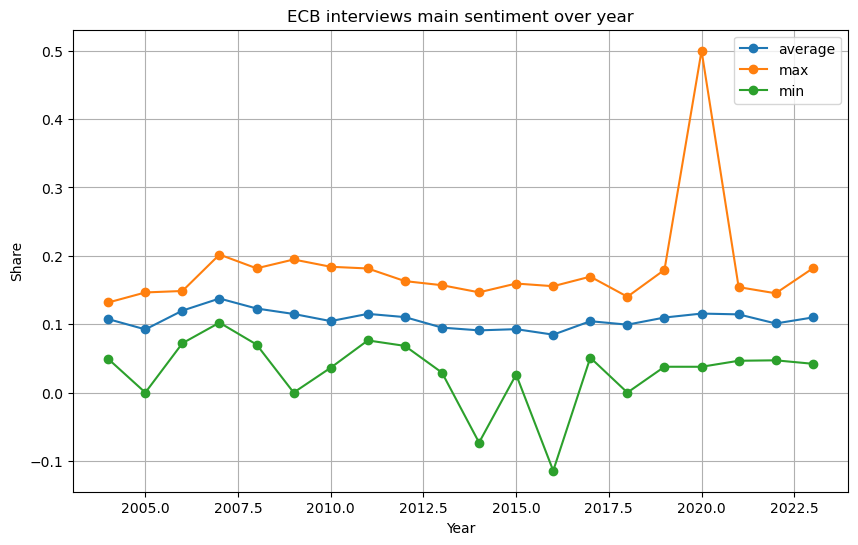

In [69]:
df_plot_mean = dataset.groupby('year')['sentiment'].mean()
df_plot_max = dataset.groupby('year')['sentiment'].max()
df_plot_min = dataset.groupby('year')['sentiment'].min()
plt.figure(figsize=(10, 6))
plt.plot(df_plot_mean.index, df_plot_mean, label='average', marker='o')
plt.plot(df_plot_mean.index, df_plot_max, label='max', marker='o')
plt.plot(df_plot_mean.index, df_plot_min, label='min', marker='o')
plt.title('ECB interviews main sentiment over year')
plt.xlabel('Year')
plt.ylabel('Share')
plt.legend()
plt.grid(True)
plt.show()

## Descriptive Methods

### Word Clouds

An easy way to identify what's going on in a text or a corpus of text: look at most recurring keywords.

- To look at most recurring keywords, a very important step is going to `clean` the data.

We must remove from it the useless information!

For now let's give it a simple try!

In [27]:
from wordcloud import WordCloud
# Make up the wordcloud
wordcloud = WordCloud(max_font_size=50, max_words=10, background_color="white").generate(
"""
This was written for the purpose of the python class. We're learning python and programming together,
and it's a lot of work. But we hope it's very rewarding because python is used throughout the world.
""")
wordcloud.words_

{'python': 1.0,
 'written': 0.3333333333333333,
 'purpose': 0.3333333333333333,
 'class': 0.3333333333333333,
 'learning': 0.3333333333333333,
 'programming': 0.3333333333333333,
 'together': 0.3333333333333333,
 'lot': 0.3333333333333333,
 'work': 0.3333333333333333,
 'hope': 0.3333333333333333}

Let's apply this function to random interviews from our corpus

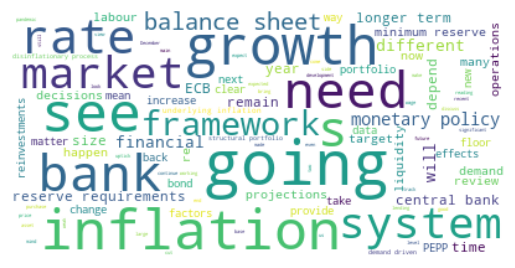

In [31]:
from wordcloud import WordCloud

# Make up the wordcloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(dataset.loc[490, 'content'])

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Cleaning the text

A lot of words in the text are actually not information you want to keep, a usual, almost necessary, step in this kind of exercise are stopword removal.

- For each language a list of words bearing no information about the content of the texts has been defined.
    - We remove all those words from our corpus

In [34]:
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
print(stopwords)

{'can', 'since', 'below', 'themselves', "how's", 'they', 'otherwise', "why's", 'only', 'off', 'above', 'from', 'on', 'our', 'each', "we'll", 'being', 'between', "they've", "couldn't", 'than', "we've", 'she', 'myself', 'more', 'also', 'doing', 'been', 'like', 'after', 'out', 'with', 'you', 'could', "let's", 'about', 'what', 'by', "he's", 'am', "i'm", 'r', 'itself', 'i', "don't", "you'll", 'yourself', 'then', 'we', 'it', "i've", 'the', 'hers', 'during', 'very', 'why', 'would', 'down', "we'd", 'while', 'so', 'their', 'of', 'once', 'no', 'its', 'if', "we're", 'for', 'whom', 'have', "hadn't", 'me', 'when', 'ever', "shan't", 'that', "where's", 'your', "doesn't", 'before', 'further', "wasn't", 'he', 'some', 'same', 'has', 'cannot', 'there', 'be', 'who', "haven't", 'else', 'k', 'over', 'nor', "what's", 'do', 'ought', "you're", 'does', "he'll", 'into', "shouldn't", 'until', 'hence', "he'd", 'com', 'a', 'own', "when's", "weren't", "mustn't", 'just', 'him', "there's", "who's", "isn't", 'his', 'sh

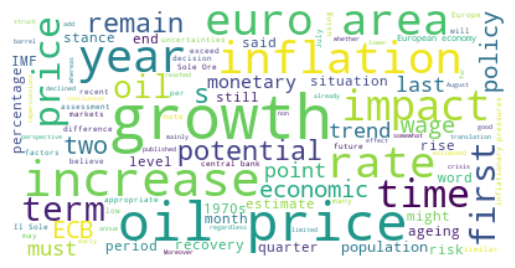

In [35]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",
                     stopwords = stopwords).generate(dataset.loc[4, 'content'])
# Display the generated image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

When words are conjugated, they don't count as the same:

- For example `grow` and `growth`, depending on the library you use, might not match together.
- A way to improve on your code is to make them match. Two processes are available to do so:
    - `Stemming` - Truncating to a root that might not exist.
    - `Lemmatizing` - going back to the word root of a term, it should exist in a dictionary.
- Both process involve modifying every word of a corpus to go back to the root of the word

We'll use the library `spacy` it's the one i'm most used to but feel free to try others:

- `nltk` is a famous alternative

In [68]:
!pip install spacy

     ---------------------------------------- 0.0/107.3 kB ? eta -:--:--
     -------------------------------------- 107.3/107.3 kB 6.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/11.7 MB 6.3 MB/s eta 0:00:02
   -- ------------------------------------- 0.6/11.7 MB 7.4 MB/s eta 0:00:02
   -- ------------------------------------- 0.9/11.7 MB 6.8 MB/s eta 0:00:02
   ---- ----------------------------------- 1.2/11.7 MB 6.8 MB/s eta 0:00:02
   ---- ----------------------------------- 1.5/11.7 MB 6.6 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/11.7 MB 6.8 MB/s eta 0:00:02
   ------- -------------------------------- 2.1/11.7 MB 6.5 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/11.7 MB 6.8 MB/s eta 0:00:02
   --------- ------------------------------ 2.6/11.7 MB 6.7 MB/s eta 0:00:02
   ---------- ----------------------------- 3.0/11.7 MB 6.9 MB/s eta 0:00:02
   ----

In [71]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.1/12.8 MB 1.7 MB/s eta 0:00:08
     - -------------------------------------- 0.4/12.8 MB 3.4 MB/s eta 0:00:04
     -- ------------------------------------- 0.6/12.8 MB 4.0 MB/s eta 0:00:04
     -- ------------------------------------- 0.9/12.8 MB 4.4 MB/s eta 0:00:03
     --- ------------------------------------ 1.2/12.8 MB 4.7 MB/s eta 0:00:03
     ---- ----------------------------------- 1.4/12.8 MB 4.8 MB/s eta 0:00:03
     ----- ---------------------------------- 1.7/12.8 MB 4.9 MB/s eta 0:00:03
     ------ --------------------------------- 1.9/12.8 MB 5.2 MB/s eta 0:00:03
     ------ --------------------------------- 2.2/12.8 MB 5.2 MB/s eta 0:00:03
     ------- -------------------------------- 2.5/12.8 MB 5.2 MB/s eta 0:00:02
     -------- ------------------------------- 2.7/12.8 MB 5.2 MB/s

In [72]:
import spacy

# Import the core library for english words
nlp = spacy.load('en_core_web_sm')

In [86]:
# Let's lemmatize a random paragraph of our dataset
random_par = dataset.sample(n=1)['content'].values[0].split('\n')
random_par = choice(random_par).split(' ')

# Remove stop words and lemmatize
random_par = ' '.join([x for x in random_par if x not in stopwords])

# Process the text using spaCy 
doc = nlp(random_par)
 
# Extract lemmatized tokens
lemmatized_tokens = [token.lemma_ for token in doc if token.is_stop == False]
 
# Join the lemmatized tokens into a sentence
lemmatized_text = ' '.join(lemmatized_tokens)
 
print(random_par, '\n')
print(lemmatized_text)

“The sale durable consumer goods grown 4.5% year, share prices risen 13% start year, price capital non-financial firms 7.7% – similar pre-crisis levels. For banks, too, funding become considerably cheaper.” In short, financial conditions improved. “Even though critics said quantitative easing less effective United States, much financing provided banks. They forget banks listed stock exchange too.”  

" sale durable consumer good grow 4.5 % year , share price rise 13 % start year , price capital non - financial firm 7.7 % – similar pre - crisis level . bank , , funding considerably cheap . " short , financial condition improve . " critic say quantitative easing effective United States , financing provide bank . forget bank list stock exchange . "


Let's also remove other parts of texts that do not contribute to us understanding its meaning from words:

    - Punctuation
    - Stopwords
    - Numbers
    - Special signs: percentages, apostrophes, quotation marks ..
    
Let's create a cleaning pipeline

In [110]:
# Clean text
def cleaning_text(text_elem):
    # You apply the spacy functions
    doc = nlp(text_elem)
    
    # We now proceed token by token, keep only the ones we want, remove the others
    doc = [token for token in doc if token.is_stop == False]
    doc = [token for token in doc if token.is_punct == False]
    doc = [token for token in doc if token.is_alpha == True]
    
    # And now we lemmatize
    doc = [token.lemma_ for token in doc if token.lemma_ != "well"]
    
    cleaned_text = ' '.join(doc)
    return(cleaned_text)

Let's try our function

In [112]:
# Let's clean a random part paragraph of our dataset
random_par = dataset.sample(n=1)['content'].values[0].split('\n')
random_par = choice(random_par)

# We clean and lemmatize
cleaned = cleaning_text(random_par)

# Print both
print(random_par, '\n')
print(cleaned)

 According to a Financial Times journalist, in the absence of structural reform Italy risks being expelled from the euro. Is that true?  

accord Financial Times journalist absence structural reform Italy risk expel euro true


We have a function we're reasonably happy with, let's apply it to all interviews:

- Even for a simple exercise like this one, it will take a very long time:
    - The code is not optimized.
    - Lemmatizing is a complicated operation, that's why some people prefer to simply stem.

But once it's done, we do not need to think about it anymore

In [113]:
# Simply apply our function/pipeline to every piece of content
#dataset['content_clean'] = dataset['content'].apply(lambda x: cleaning_text(x))
dataset = pd.read_csv('interviews_cleaned.csv')

Let's try with random sample of wordclouds and see if the result is better - but for this kind of analysis it shouldn't make such a big difference

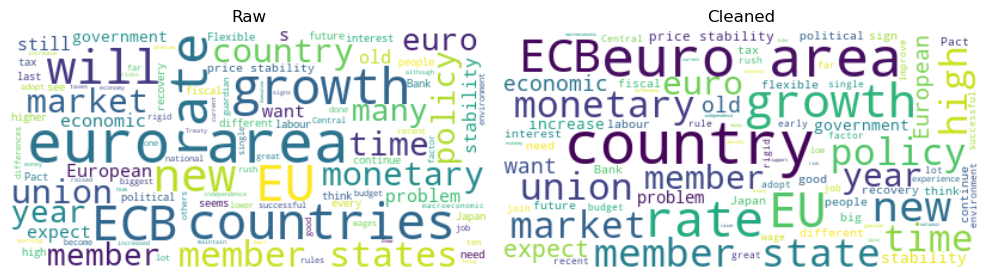

In [119]:
idx = 7
wordcloud1 = WordCloud(max_font_size=50, max_words=100, background_color="white",
                     stopwords = stopwords).generate(dataset.loc[idx, 'content'])
wordcloud2 = WordCloud(max_font_size=50, max_words=100, background_color="white",
                     stopwords = stopwords).generate(dataset.loc[idx, 'content_clean'])
# Display the generated image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))  # Adjust figsize to fit your screen

# Display word cloud images
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Raw')

ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.axis("off")
ax2.set_title('Cleaned')

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

### Exercise 14: Let's create 3 wordclouds.

- Join together the interviews from 2004 to 2008
- Join together the interviews from 2008 to 2013
- Join together the interviews from 2014 to 2019

Then we apply our wordclouds, and see if we can see differences between the different eras of the ECB

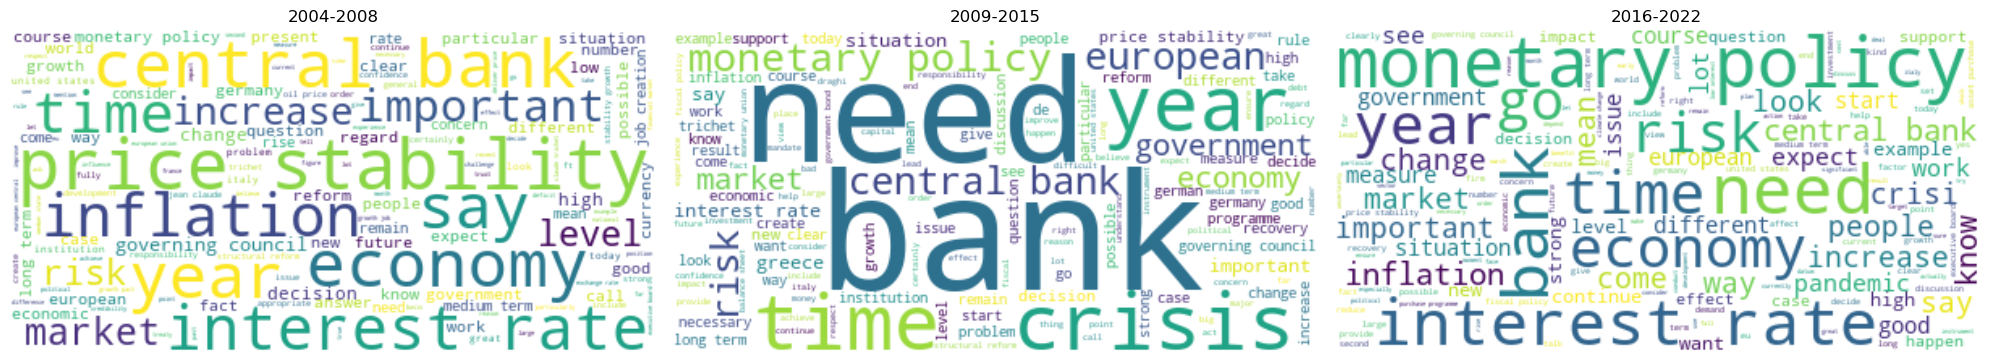

In [124]:
first_corpus = ' '.join(dataset.loc[(dataset['year'] <= 2008) , 'content_clean'].tolist()).lower()
second_corpus = ' '.join(dataset.loc[(dataset['year'] <= 2015) & (dataset['year'] > 2008), 'content_clean'].tolist()).lower()
third_corpus = ' '.join(dataset.loc[(dataset['year'] > 2015), 'content_clean'].tolist()).lower()
# Make up the wordcloud
add_other_stopword = ['area', 'europe', 'euro', 'country', 'ecb', 'think']
[STOPWORDS.add(x) for x in add_other_stopword]

wordcloud1 = WordCloud(max_font_size=100, background_color="white", stopwords = STOPWORDS).generate(first_corpus)
wordcloud2 = WordCloud(max_font_size=100, background_color="white", stopwords = STOPWORDS).generate(second_corpus)
wordcloud3 = WordCloud(max_font_size=100, background_color="white", stopwords = STOPWORDS).generate(third_corpus)

# Setup a matplotlib figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))  # Adjust figsize to fit your screen

# Display word cloud images
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.axis("off")
ax1.set_title('2004-2008')

ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.axis("off")
ax2.set_title('2009-2015')

ax3.imshow(wordcloud3, interpolation='bilinear')
ax3.axis("off")
ax3.set_title('2016-2022')

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

This kind of analysis, whilst not being very useful in general for academic papers, can make for very nice visualizations!

- see https://www.datacamp.com/tutorial/wordcloud-python for more on this

### Learning based methods

What is learning?

- Unsupervised learning.
    - Algorithmic based.
    - Neural network based.
- Supervised learning.
    - Annotated data.

### Unsupervised learning

A very guided version of it. Unsupervised learning rarely corresponds to what we imagine machine learning is

- Latent Dirichlet Allocation (LDA) - today
- Principal component analysis - often interpreted as unsupervised learning
- k-methods

### Topic modelling

The kind of unsupervised learning we'll apply is called Latent Dirichlet Allocation:

- In a corpora of texts, we want to identify the items that are similar to each others.

How?

- You assume that documents in your corpora, have a distinct topics.
- You assume a document from a topics has probability to contain specific words.

Given these assumptions, you have a certain probability to observe the texts.

- You assign each text to each topics so as to maximize that probability

On the documents side, the information extracted by this algorithm will be:

- Document 1 of our corpus is 85% topic A, 10% topic B, 5% the rest
- Document 2 of our corpus is ...

and on the topic sides:

- Topic A is characterized in 90% of the times by word xxx, by word yyy in 80% of the time..
- Topic B is characterized in ...

We'll use yet another package. For MAC and Linux users installing these packages is very easy, just type the usual `pip install`, but you need to `downgrade` the library `scipy` because `gensim` is built on functions from `scipy` that no longer exist.

For PC users you might also need to :

- go to: https://visualstudio.microsoft.com/visual-cpp-build-tools/
- download build tools and install the base
- go to "visual studio installer" and modify the build of "visual studio build tools 2022"
- include in your build the desktop development C++
- Reboot your PC

In [407]:
!pip install gensim
!pip install scipy==1.12.0

  Using cached lda-2.0.0.tar.gz (320 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pbr-3.1.1-py2.py3-none-any.whl.metadata (2.9 kB)
Using cached pbr-3.1.1-py2.py3-none-any.whl (99 kB)
  Running setup.py clean for lda
Failed to build lda


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [161 lines of output]
  C:\Users\anato\anaconda3\envs\python-econ\Lib\site-packages\setuptools\dist.py:498: SetuptoolsDeprecationWarning: Invalid dash-separated options
  !!
  
          ********************************************************************************
          Usage of dash-separated 'description-file' will not be supported in future
          versions. Please use the underscore name 'description_file' instead.
  
          This deprecation is overdue, please update your project and remove deprecated
          calls to avoid build errors in the future.
  
          See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
          ********************************************************************************
  
  !!
    opt = self.warn_dash_deprecation(opt, section)
  C:\Users\anato\anaconda3\envs\python-econ\Lib\site-pac

With most libraries, to perform any text analysis, a text pre-processing step is extremely important.

- For demonstration purposes, we'll keep pre-processing to a minimum but somes steps cannot be ignored to first run the function.
- We'll see that with minimal pre-processing, it's impossible to get meaningful results.

In [132]:
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Take our documents, transform it so that each word is divided
documents = dataset.loc[: , 'content_clean'].tolist()
processed_texts  = [[word for word in doc.split(' ')] for doc in documents]
 
id2word = corpora.Dictionary(processed_texts)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in processed_texts]

In [133]:
from gensim.models.ldamodel import LdaModel
import pandas as pd

# Set number of topics
num_topics = 10

# Build LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, passes=10, alpha="auto", per_word_topics=True)

In [134]:
from pprint import pprint

pprint(lda_model.print_topics())

[(0,
  '0.026*"die" + 0.014*"und" + 0.013*"der" + 0.010*"das" + 0.010*"ist" + '
  '0.009*"nicht" + 0.008*"auch" + 0.007*"es" + 0.007*"zu" + 0.007*"für"'),
 (1,
  '0.017*"euro" + 0.014*"bank" + 0.012*"ECB" + 0.011*"area" + 0.010*"country" '
  '+ 0.007*"market" + 0.007*"rate" + 0.007*"price" + 0.006*"financial" + '
  '0.006*"year"'),
 (2,
  '0.017*"de" + 0.009*"dat" + 0.009*"van" + 0.008*"het" + 0.008*"een" + '
  '0.008*"price" + 0.007*"en" + 0.006*"risk" + 0.006*"zijn" + 0.005*"die"'),
 (3,
  '0.019*"Draghi" + 0.011*"ECB" + 0.010*"rate" + 0.009*"country" + '
  '0.008*"market" + 0.008*"SPIEGEL" + 0.008*"interest" + 0.008*"bank" + '
  '0.007*"reform" + 0.007*"euro"'),
 (4,
  '0.017*"inflation" + 0.012*"think" + 0.011*"year" + 0.008*"die" + '
  '0.007*"bank" + 0.007*"energy" + 0.006*"rate" + 0.006*"need" + 0.005*"cent" '
  '+ 0.005*"high"'),
 (5,
  '0.018*"AskECB" + 0.012*"euro" + 0.009*"ECB" + 0.008*"country" + '
  '0.007*"area" + 0.007*"economy" + 0.007*"policy" + 0.006*"year" + '
  '0.0

In [135]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=id2word, coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score: ", coherence_lda)

Coherence Score:  0.44322190677107304


Now we want to visualize what happens

In [22]:
!pip install pyLDAvis

   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB 1.3 MB/s eta 0:00:03
   ----- ---------------------------------- 0.3/2.6 MB 5.2 MB/s eta 0:00:01
   ---------- ----------------------------- 0.7/2.6 MB 5.9 MB/s eta 0:00:01
   ---------------- ----------------------- 1.1/2.6 MB 6.1 MB/s eta 0:00:01
   --------------------- ------------------ 1.4/2.6 MB 6.8 MB/s eta 0:00:01
   --------------------------- ------------ 1.8/2.6 MB 6.7 MB/s eta 0:00:01
   -------------------------------- ------- 2.1/2.6 MB 6.7 MB/s eta 0:00:01
   -------------------------------------- - 2.5/2.6 MB 7.0 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 6.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/97.1 kB ? eta -:--:--
   ---------------------------------------- 97.1/97.1 kB 5.4 MB/s eta 0:00:00


In [136]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)

In [137]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.163166 -0.024653       1        1  46.745666
1      0.157579 -0.037908       2        1  28.553750
8      0.152271 -0.021041       3        1  13.900875
5      0.111692 -0.037011       4        1   3.747897
4      0.016991  0.115129       5        1   2.069542
3      0.088377 -0.026297       6        1   1.849499
7     -0.298867 -0.197338       7        1   1.531569
0     -0.184011  0.209358       8        1   1.017772
2     -0.073282 -0.001746       9        1   0.580522
9     -0.133917  0.021507      10        1   0.002908, topic_info=          Term         Freq        Total Category  logprob  loglift
617  inflation  4488.000000  4488.000000  Default  30.0000  30.0000
7          ECB  5194.000000  5194.000000  Default  29.0000  29.0000
62        bank  4401.000000  4401.000000  Default  28.0000  28.0000
127       euro  4935.000000  4935.000000  Default  27.0000  27.0000
261       rate  4353.000000  4353.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
204       long     0.008391  1801.716159  Topic10  -7.4483  -1.8316
174  important     0.008330  1783.233383  Topic10  -7.4556  -1.8285
99     country     0.010077  3525.284715  Topic10  -7.2652  -2.3197
312       term     0.008871  2298.255672  Topic10  -7.3927  -2.0193
315       time     0.008797  2336.730228  Topic10  -7.4010  -2.0443

[771 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
11576      1  0.948905    Advanced
7918       5  0.754169     Amerika
8818       2  0.959902  Aschmoneit
13002      1  0.044297      AskECB
13002      3  0.005537      AskECB
...      ...       ...         ...
338        3  0.031568           à
338        4  0.023676           à
338        7  0.686599           à
10064      7  0.962064          ça
7657       7  0.953260        être

[1831 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 9, 6, 5, 4, 8, 1, 3, 10])

We have some interviews that are either in French or German. That's not good. We want to drop those interviews, because the topic analysis concentrated on those interviews:

- We can use langdetect to do so.

In [141]:
!pip install langdetect

     ---------------------------------------- 0.0/981.5 kB ? eta -:--:--
      ------------------------------------ 20.5/981.5 kB 682.7 kB/s eta 0:00:02
     ---------- --------------------------- 266.2/981.5 kB 3.3 MB/s eta 0:00:01
     --------------------- ---------------- 553.0/981.5 kB 5.0 MB/s eta 0:00:01
     -------------------------------- ----- 829.4/981.5 kB 5.3 MB/s eta 0:00:01
     -------------------------------------- 981.5/981.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993253 sha256=b1e8e37314af16175f5bcb14d07369519425f0a35affec4055e72c0ed8624af0
  Stored in directory: c:\users\anato\appdata\local\pip\cache\wheels\c1\67\88\e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [143]:
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

# Add a column to the dataset
dataset['language'] = dataset['content'].apply(lambda x: detect(x))
dataset['language'].value_counts()

So now we limit ourselves to texts in English

In [145]:
dataset = dataset.loc[dataset['language'] == 'en']

Let's repeat all of our previous analysis

In [146]:
# Take our documents, transform it so that each word is divided
documents = dataset.loc[: , 'content_clean'].tolist()
processed_texts  = [[word for word in doc.split(' ')] for doc in documents]
 
id2word = corpora.Dictionary(processed_texts)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in processed_texts]


# Set number of topics
num_topics = 10

# Build LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, passes=10, alpha="auto", per_word_topics=True)

In [147]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.032244  0.060313       1        1  26.213758
6     -0.053969 -0.040325       2        1  24.184191
4     -0.031106 -0.008626       3        1  18.906289
2     -0.041927 -0.003783       4        1  16.248040
8     -0.011667  0.009233       5        1   4.383025
1     -0.053165  0.034258       6        1   4.293296
0      0.015633 -0.112734       7        1   2.352255
5      0.051845  0.046685       8        1   1.352781
9      0.048253  0.016816       9        1   1.327092
7      0.108347 -0.001836      10        1   0.739273, topic_info=           Term         Freq        Total Category  logprob  loglift
7           ECB  5102.000000  5102.000000  Default  30.0000  30.0000
62         bank  4312.000000  4312.000000  Default  29.0000  29.0000
617   inflation  4602.000000  4602.000000  Default  28.0000  28.0000
261        rate  4329.000000  4329.000000  Default  27.0000  27.0000
702      policy  4618.000000  4618.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
337        year    13.109916  3002.032337  Topic10  -5.6003  -0.5264
285        risk    12.186666  2493.891402  Topic10  -5.6733  -0.4140
596      growth    11.887772  2185.841277  Topic10  -5.6982  -0.3070
159  government    11.602997  1866.074145  Topic10  -5.7224  -0.1731
174   important    11.434868  1791.293740  Topic10  -5.7370  -0.1468

[847 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
6816       4  0.320454  ACPR
6816       9  0.640908  ACPR
10992      8  0.864793   AIT
7353       1  0.903493   APP
7353       3  0.015185   APP
...      ...       ...   ...
827        4  0.008477  zone
827        5  0.237369  zone
827        9  0.033910  zone
827       10  0.008477  zone
9823      10  0.800170     è

[2636 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 5, 3, 9, 2, 1, 6, 10, 8])

We still have a lot of terms that appear in too many subjects. We can have one or both of the two issues:

- Words that are meaningless to differentiate between interviews because they are everywhere.
- Too many topics, so in any case there will be several repeated topics.

We want to work on both. Starting with removing words like "ECB", "AskECB".

Let's do it again

In [148]:
# Take our documents, transform it so that each word is divided
documents = dataset.loc[: , 'content_clean'].tolist()
processed_texts  = [[word for word in doc.split(' ') if word not in ['ECB', 'AskECB']] for doc in documents]
 
id2word = corpora.Dictionary(processed_texts)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in processed_texts]


# Set number of topics
num_topics = 10

# Build LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, passes=10, alpha="auto", per_word_topics=True)

In [149]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.070178 -0.004544       1        1  31.367964
3     -0.087473 -0.018704       2        1  22.294611
5     -0.046878  0.024460       3        1  19.431804
8     -0.066767 -0.001095       4        1  11.447397
1     -0.063310  0.050362       5        1   9.984167
4     -0.029943  0.017448       6        1   3.182609
2      0.032952 -0.126479       7        1   1.304731
9      0.106164  0.070725       8        1   0.477716
0      0.094668 -0.029932       9        1   0.316809
6      0.130766  0.017759      10        1   0.192192, topic_info=           Term         Freq        Total Category  logprob  loglift
616   inflation  4578.000000  4578.000000  Default  30.0000  30.0000
701      policy  4580.000000  4580.000000  Default  29.0000  29.0000
61         bank  4330.000000  4330.000000  Default  28.0000  28.0000
126        euro  4806.000000  4806.000000  Default  27.0000  27.0000
206      market  3031.000000  3031.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
52         area     2.715334  3455.309932  Topic10  -5.8157  -0.8943
1273     crisis     2.397667  2440.688064  Topic10  -5.9402  -0.6711
1678   purchase     2.130421  1254.868252  Topic10  -6.0583  -0.1240
1064  financial     2.223341  2146.639309  Topic10  -6.0156  -0.6182
78       change     2.122440  1371.563029  Topic10  -6.0621  -0.2167

[849 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
8936      8  0.822798      AMCs
5438      3  0.955362    Aachen
8629      7  0.960752  Advanced
8630      3  0.134865    Aghion
8630      7  0.809188    Aghion
...     ...       ...       ...
826       3  0.243553      zone
826       4  0.092382      zone
826       5  0.117577      zone
826       6  0.260350      zone
9822      5  0.859477         è

[2421 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 6, 9, 2, 5, 3, 10, 1, 7])

A lot of our topics are overlapping. Let's try to reduce the number of topics, whilst keeping in mind measurements of the quality of our classification.

In [150]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=id2word, coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score: ", coherence_lda)

Coherence Score:  0.3009619890788271


In [151]:
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=5, random_state=42, passes=10, alpha="auto", per_word_topics=True)

coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=id2word, coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score: ", coherence_lda)

Coherence Score:  0.3121164809337077


Slightly better from a numeric perspective, let's get a visual perspective again

In [152]:
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.023563 -0.005357       1        1  30.101866
1      0.025304  0.050159       2        1  27.431048
2      0.077077 -0.033305       3        1  19.054774
0     -0.088522 -0.013063       4        1  12.880540
4      0.009704  0.001566       5        1  10.531771, topic_info=            Term         Freq        Total Category  logprob  loglift
616    inflation  4482.000000  4482.000000  Default  30.0000  30.0000
313        think  2702.000000  2702.000000  Default  29.0000  29.0000
156           go  1542.000000  1542.000000  Default  28.0000  28.0000
126         euro  4690.000000  4690.000000  Default  27.0000  27.0000
10390   pandemic  1004.000000  1004.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
184     interest   196.146710  2400.716613   Topic5  -5.5394  -0.2539
98       country   216.551206  3470.952904   Topic5  -5.4405  -0.5236
643          low   174.922957  1718.669945   Topic5  -5.6540  -0.0342
614     increase   170.608525  1624.548259   Topic5  -5.6789  -0.0028
1273      crisis   174.906358  2422.241525   Topic5  -5.6541  -0.3774

[476 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
7352      1  0.291403     APP
7352      2  0.038343     APP
7352      4  0.621149     APP
7352      5  0.046011     APP
5438      3  0.899778  Aachen
...     ...       ...     ...
336       2  0.203254    year
336       3  0.194978    year
336       4  0.207226    year
336       5  0.075806    year
3524      3  0.957086    zeit

[1150 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1, 5])